In [1]:
import haiku as hk
import jax
import jax.random as jrnd
import jax.numpy as jnp

import numpy as np
import optax

In [2]:
from phasor_jax.modules import *
from phasor_jax.utils import *
from phasor_jax.training import *

In [3]:
import matplotlib.pyplot as plt

# Dataset

In [4]:
#choose standard dataset here - e.g. MNIST, Fashion MNIST, Kuzushiji MNIST
dataset = "fashion_mnist"

In [5]:
#load the dataset
n_batch = 128
train_ds, x_train, y_train = load_dataset(dataset, split="train", is_training=True, batch_size=n_batch)
train = iter(train_ds)

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-03-20 16:00:13.742769: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [6]:
n_train = x_train.shape[0]
x_train.shape

(60000, 28, 28, 1)

# Model

In [7]:
def mlp(x, 
           vsa_dimension: int = 1024,
           spiking: bool = False,
           **kwargs):
    
    x = scale_mnist(x)
    #project into VSA
    x = ProjectAll(vsa_dimension)(x)
    x = layer_norm(x)

    if spiking:
        x = phase_to_train(x)
    
    x = conv_1d(128)(x, spiking=spiking)
    x = conv_1d(10)(x,  spiking=spiking)
     
    return x

In [8]:
#declare the model as a transformation
model = hk.transform(mlp)

In [9]:
#instantiate the first PRNG key
key = jrnd.PRNGKey(42)

In [10]:
#split the key and use it to create the model's initial parameters
key, subkey = jrnd.split(key)
params = model.init(subkey, x_train[0:10,...])

/Users/wilkie/anaconda3/envs/jax/lib/python3.10/site-packages/haiku/_src/base.py:515: UserWarning: Explicitly requested dtype float requested in ones is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


In [11]:
#get a sample batch from the train set
b = next(train)
x = b['image']
y = b['label']

b x y c ->  (128, 28, 28, 1)


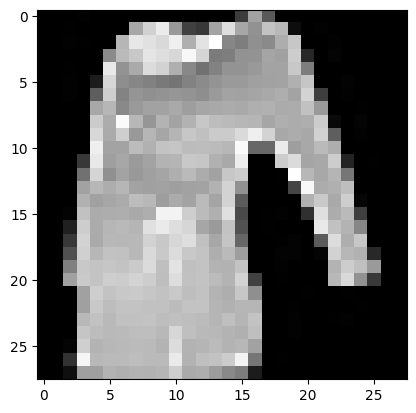

In [12]:
print("b x y c -> ", x.shape)
plt.imshow(x[0,...], cmap="gray");

In [13]:
model.apply(params, key, x, spiking=False)

DeviceArray([[ 0.49045837,  0.32804522,  0.3856396 , ..., -0.0478965 ,
              -0.11704593,  0.01182345],
             [ 0.07235594, -0.08874349,  0.14551952, ...,  0.2911517 ,
               0.06611723,  0.01925142],
             [-0.19301961,  0.05119936, -0.26339725, ...,  0.12291995,
              -0.12575562,  0.22134064],
             ...,
             [ 0.16044085,  0.13906515,  0.08830648, ...,  0.01166629,
              -0.05248075, -0.187418  ],
             [ 0.3184937 , -0.09649571, -0.00215887, ..., -0.13396761,
               0.04695809, -0.13647969],
             [ 0.01672154, -0.15465826,  0.50306684, ..., -0.26757655,
               0.08661724, -0.17403792]], dtype=float32)

In [14]:
spks = model.apply(params, key, x, spiking=True)

Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 562.94it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 3432.07it/s]


In [15]:
len(*spks.indices)

13127

In [16]:
len(spks.times)

13127

In [17]:
spks.full_shape

(128, 10)

In [18]:
np.prod(spks.full_shape)

1280

In [19]:
p = train_to_phase(spks, offset=0.25)

In [20]:
spks.times

array([0.5 , 1.48, 2.42, ..., 7.7 , 8.71, 9.71])

In [21]:
np.max(spks.times)

10.0

In [22]:
np.ceil(spks.times[-1]) // 1.0

10.0

In [23]:
len(spks.times)

13127

In [24]:
spks.full_shape

(128, 10)

In [25]:
def spiking_sparsity(x: SpikeTrain, period: float = 1.0):
    end_time = np.max(x.times)
    periods = np.ceil(end_time) // period
    total_spikes = len(x.times)
    total_neurons = np.prod(x.full_shape)

    sparsity = total_spikes / (total_neurons * periods)
    return sparsity

In [26]:
spiking_sparsity(spks)

1.025546875

In [27]:
p = train_to_phase(spks, offset = 0.25)

In [28]:
p.shape

(128, 10, 11)

In [33]:
acc = accuracy_quadrature(p, y)

In [34]:
acc.shape

(11, 128)

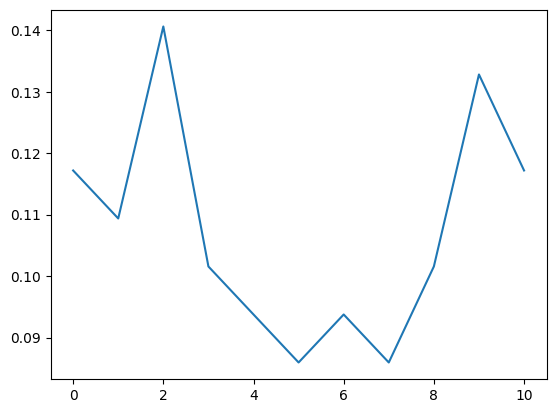

In [35]:
plt.plot(np.mean(acc, axis=1))

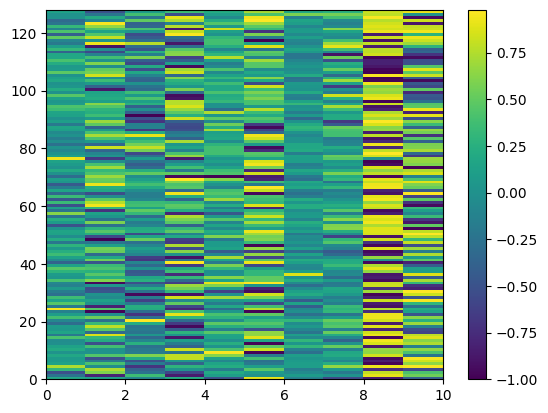

In [63]:
plt.pcolor(p[:,:,-3])
plt.colorbar()

(array([ 86.,  44.,  69., 101., 172., 253., 183., 133., 108., 131.]),
 array([-1.   , -0.802, -0.604, -0.406, -0.208, -0.01 ,  0.188,  0.386,
         0.584,  0.782,  0.98 ]),
 <BarContainer object of 10 artists>)

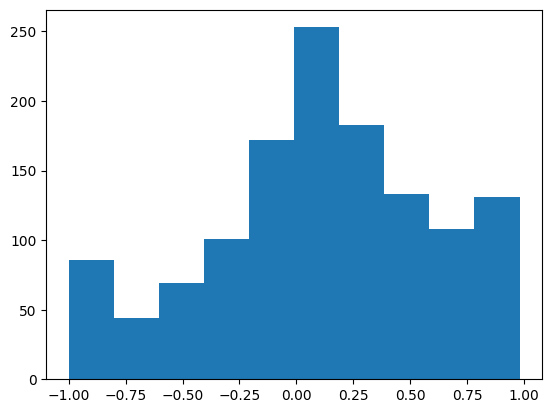

In [64]:
plt.hist(p[:,:,-3].ravel())